In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"
%cd drive/MyDrive/Colab\ Notebooks

Mounted at /content/drive
a	    efficientnet.ipynb	    landmark_retrieval.ipynb  resnet.ipynb
caltech256  genre.ipynb		    learning.txt	      result_jpg_300
delf.ipynb  image_captioning.ipynb  mbart_translation.ipynb
/content/drive/MyDrive/Colab Notebooks


In [2]:
!pip install faiss-cpu --no-cache
!pip install efficientnet_pytorch

     |████████████████████████████████| 8.4 MB 7.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4f5e319c4bda26c51f4b6c9a9d8151c66b31bca87d398fd86bf8b71bcd860e11
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
import torch
import torchvision
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import os
import faiss

from pathlib import Path
from collections import defaultdict
from efficientnet_pytorch import EfficientNet

In [4]:
# Choose RfficientNet-B0 model with ImageNet pretrained weights
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1000)
model.eval()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [5]:
# # for Imat2011 dataset
# image_group = 10
# path_tmpl = 'result_jpg_300/' + '%d_%d.jpg'
# paths = [path_tmpl % (image_group, i) for i in range(1,6)]
# imgs = [cv.imread(path) for path in paths]

# for Caltech256 dataset
imgs = []
categories = []
for root, _, _ in os.walk("caltech256/"):
    category = root[12:14]
    if root != "caltech256/":
        for filename in os.listdir(root):
          img = cv.imread(os.path.join(root, filename))
          imgs.append(img)
          categories.append(category)

In [ ]:
imgs = [cv.resize(img, (224, 224), interpolation = cv.INTER_AREA) for img in imgs]

In [6]:
# # for Imat2011 dataset:
# # path_labels = PATH_PROJECT / '.data/imat2011/learning.txt'
# path_labels = 'learning.txt'

# def get_labels(path_lables):
    
#     with open(path_lables, 'r', newline='\n') as fin:
#         learning = [line.strip() for line in fin]
    
#     learning_dict = defaultdict(set)
#     for l in learning:
#         g, i = l.split('.')[0].split('_')
#         learning_dict[int(g)].add(int(i))
    
#     return learning_dict

# learning_dict = get_labels(path_labels)

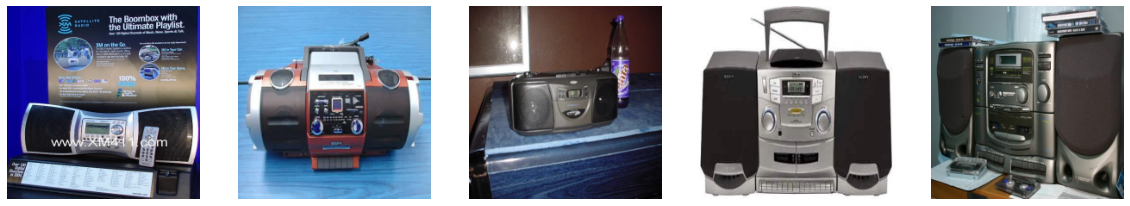

In [7]:
plt.figure(figsize=(20, 10))
# for i, img in enumerate(imgs, 1):
for i, img in enumerate(imgs[:5], 1):
    ax = plt.subplot(1, 5, i)
    plt.imshow(img)
    # if i in learning_dict[image_group]:
    #     plt.title("SET %d" % i)
    # else:
    #     plt.title("%d" % i)
    plt.axis("off")

In [8]:
# # for Imat2011 dataset:
# imgs = []
# root = "result_jpg_300/"
# for filename in os.listdir(root):
#     img = cv.imread(os.path.join(root,filename))
#     img = cv.resize(img, (224, 224), interpolation = cv.INTER_AREA)
#     imgs.append(img)

In [ ]:
imgs = np.array(imgs)

In [9]:
# Get image embeddings
embeddings = []
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = [preprocess(img) for img in imgs]
for img in input_tensor:
    input_batch = img.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    embeddings.append(output.cpu().numpy())

In [10]:
embeddings = np.array(embeddings)
embeddings = embeddings.reshape((-1, 1000))

In [11]:
# Search similar embeddings by Faiss
index = faiss.IndexFlatL2(1000)
index.add(embeddings)

In [15]:
k = 10
image_idx = 100 # Set index of query image
D, I = index.search(embeddings[image_idx].reshape((1, 1000)), k)

In [16]:
# Show indexes and distances
I, D

(array([[ 100,   99,  110,   92,  128,  151, 1839,  123,  163,   96]]),
 array([[   0.     ,  730.4234 ,  831.26227,  844.9889 ,  847.7498 ,
          853.7722 ,  923.9871 ,  982.7458 ,  985.0092 , 1028.0833 ]],
       dtype=float32))

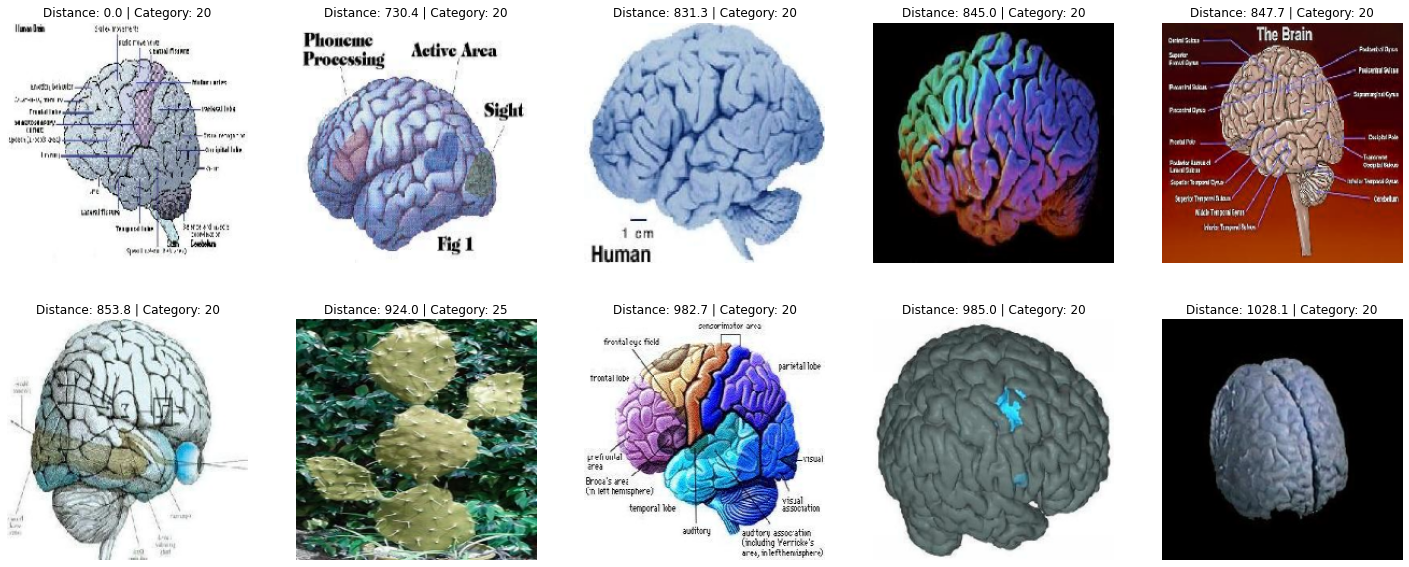

In [17]:
plt.figure(figsize=(25, 10))
for i, idx in enumerate(I[0], 1):
    ax = plt.subplot(2, 5, i)
    plt.imshow(imgs[idx])
    plt.title("Distance: " + str(round(D[0][i - 1], 1)) + " | Category: " + str(categories[idx]))
    plt.axis("off")